# Landmark Registration: PyTorch

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
np.random.seed(42)
torch.set_default_dtype(torch.float64)

## Define Transformation
Reference: https://pytorch.org/docs/stable/notes/modules.html

In [3]:
from torch.nn import Module
from torch.nn import Parameter

class LandmarkAffineTransform(Module):
    """Affine transformation for landmarks."""

    def __init__(self):
        super().__init__()
        # Define the transformation parameters
        self._linear_matrix = Parameter(torch.eye(3))
        self._translation = Parameter(torch.zeros(3))
        
    def forward(self, moving_landmarks):
        """Forward the model.
        
        moving_landmarks is supposed to be in a shape of (N, 3).
        """
        return moving_landmarks @ self._linear_matrix + self._translation

    def transform_numpy(self, moving_landmarks):
        """Apply transformation and get result in numpy."""
        return self.forward(torch.tensor(moving_landmarks)).detach().numpy()

    def get_linear_matrix(self):
        """Get the linear transform matrix in numpy."""
        return self._linear_matrix.detach().clone().numpy()

    def get_translation(self):
        """Get the translation vector in numpy."""
        return self._translation.detach().clone().numpy()

## Define Registration
Reference: https://pytorch.org/docs/stable/optim.html

In [4]:
def landmark_affine_registrate(
    fixed_landmarks,
    moving_landmarks,
    lr=0.001, n_iter=100
):
    """
    fixed_landmarks, moving_landmarks: array with shape (N, 3)
    lr: learning rate
    n_iter: number of iterations
    """
    fixed_landmarks = torch.tensor(fixed_landmarks)
    moving_landmarks = torch.tensor(moving_landmarks)

    transform = LandmarkAffineTransform()

    optimizer = torch.optim.Adam(
        transform.parameters(),
        lr=lr
    )

    loss_fn = torch.nn.MSELoss()

    loss_history = []
    for i in range(n_iter):
        def closure():
            optimizer.zero_grad()
            transformed_landmarks = transform(moving_landmarks)
            loss = loss_fn(fixed_landmarks, transformed_landmarks)
            loss_history.append(loss.detach().clone().numpy())
            loss.backward()
            return loss
        optimizer.step(closure)
        
    # Make a diagnostic plot
    plt.plot(loss_history)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.xlim(0)
    plt.ylim(0)
    plt.minorticks_on()
    plt.grid()
    plt.grid(which='minor', ls=':')

    return transform, loss_history

## Test Problem

In [5]:
n_landmarks = 5
fixed_landmarks = np.random.rand(n_landmarks, 3) * 10
moving_landmarks = fixed_landmarks + np.random.rand(n_landmarks, 3)

/home/b2dong/miniconda3/envs/pipeline/lib/python3.9/site-packages/torch/autograd/__init__.py:145: UserWarning: CUDA initialization: CUDA driver initialization failed, you might not have a CUDA gpu. (Triggered internally at  /opt/conda/conda-bld/pytorch_1616554782469/work/c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(


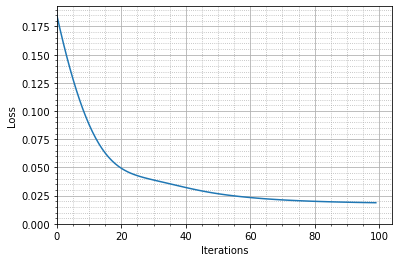

In [6]:
transform, loss_history = landmark_affine_registrate(
    fixed_landmarks,
    moving_landmarks,
)

In [7]:
transform.get_linear_matrix()

array([[ 0.95142403, -0.04700864, -0.01534379],
       [ 0.00635128,  1.0063938 , -0.03176606],
       [-0.00986211, -0.03325462,  0.98938811]])

In [8]:
transform.get_translation()

array([-0.03993392, -0.03444569, -0.03270647])

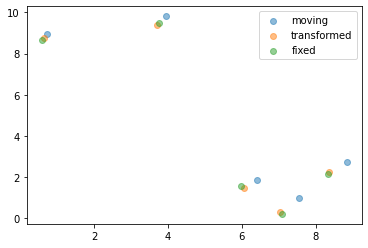

In [9]:
transformed_landmarks = transform.transform_numpy(moving_landmarks)
kwargs = {
    'alpha': 0.5
}
plt.scatter(moving_landmarks[:, 0], moving_landmarks[:, 1], label='moving', **kwargs)
plt.scatter(transformed_landmarks[:, 0], transformed_landmarks[:, 1], label='transformed', **kwargs)
plt.scatter(fixed_landmarks[:, 0], fixed_landmarks[:, 1], label='fixed', **kwargs)
plt.legend()
plt.show()

## The 4-Point Perfect Alignment Test
In 3D, if we are going to align 4 points using an affine transformation, we shall be able to find an affine transformation that does the alignment perfectly. This is because a 3D affine transformation has 12 parameters, and 4 points in 3D pose 12 constraints. In non-degenerate cases, these shall give a unique solution. I haven't found a reference yet but I believe this is correct.

So as a sanity check, here I set up a 4-point alignment problem, and see if the loss goes to 0.

In [10]:
n_landmarks = 4
fixed_landmarks = np.random.rand(n_landmarks, 3) * 10
moving_landmarks = fixed_landmarks + np.random.rand(n_landmarks, 3)

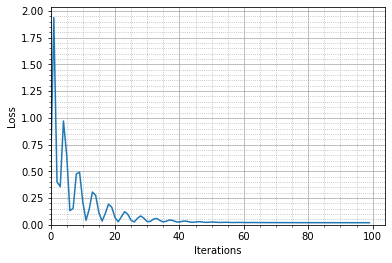

In [11]:
transform, loss_history = landmark_affine_registrate(
    fixed_landmarks,
    moving_landmarks,
    lr=0.1, n_iter=100,
)

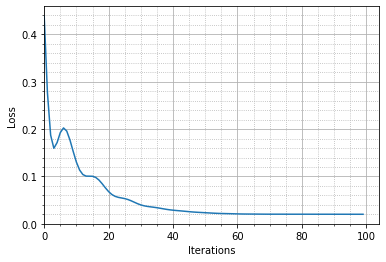

In [12]:
transform, loss_history = landmark_affine_registrate(
    fixed_landmarks,
    moving_landmarks,
    lr=0.01, n_iter=100,
)

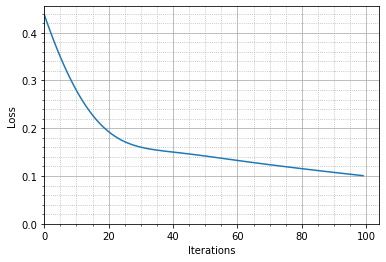

In [13]:
transform, loss_history = landmark_affine_registrate(
    fixed_landmarks,
    moving_landmarks,
    lr=0.001, n_iter=100,
)

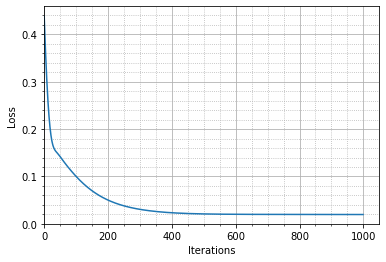

In [14]:
transform, loss_history = landmark_affine_registrate(
    fixed_landmarks,
    moving_landmarks,
    lr=0.001, n_iter=1000,
)

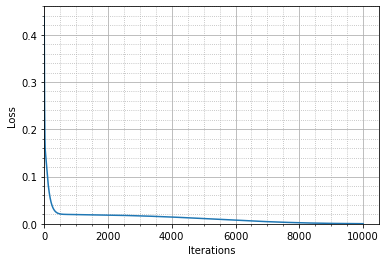

In [15]:
transform, loss_history = landmark_affine_registrate(
    fixed_landmarks,
    moving_landmarks,
    lr=0.001, n_iter=10000,
)